In [1]:
# This notebook's effort is to download, organize, and join meteorological data into the existing dataset to specify
# the wind speed, sea state (wave height), and air temperature at a given piracy event


In [56]:
from IPython.display import IFrame
%matplotlib inline
import matplotlib.pyplot as plt
import pydap
import pandas as pd
import numpy as np
import math
import datetime
from datetime import timedelta
import os
import getpass
import xarray as xr
import panel.widgets as pnw
import panel as pn
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import copernicus_marine_client  as copernicus_marine

# To avoid warning messages
import warnings
warnings.filterwarnings('ignore')

In [3]:
## Product's parameter for GLOBAL_ANALYSISFORECAST_WAV_001_027 wave heights 
datasetID = 'cmems_mod_glo_wav_anfc_0.083deg_PT3H-i'

In [4]:
#Super nice because its is a 24 GB dataset but doesn't download to my computer. I can work with it here in the notebook 
#and save the data I actually want to a different file later. Drawback is could lose all I'm working on if connection to server goes down 
#only three variables I care about
#This data is only from 30 Sep 2021 to 25 Mar 2024 - will need to extend with other or just show as use-case
DS = copernicus_marine.open_dataset(dataset_id = datasetID)
DS

#Username: mgalvan
#Passwrd: 27OviedoSpain

INFO - 2024-03-16T17:53:37Z - Dataset version was not specified, the latest one was selected: "202311"
INFO - 2024-03-16T17:53:37Z - Dataset part was not specified, the first one was selected: "default"
INFO - 2024-03-16T17:53:40Z - Service was not specified, the default one was selected: "arco-geo-series"
username: mgalvan
password: ········


<xarray.Dataset>
Dimensions:    (time: 7256, latitude: 2041, longitude: 4320)
Coordinates:
  * latitude   (latitude) float64 -80.0 -79.92 -79.83 ... 89.83 89.92 90.0
  * longitude  (longitude) float64 -180.0 -179.9 -179.8 ... 179.8 179.8 179.9
  * time       (time) datetime64[ns] 2021-10-01T03:00:00 ... 2024-03-26
Data variables: (12/18)
    VCMX       (time, latitude, longitude) float32 ...
    VHM0       (time, latitude, longitude) float32 ...
    VHM0_SW1   (time, latitude, longitude) float32 ...
    VHM0_SW2   (time, latitude, longitude) float32 ...
    VHM0_WW    (time, latitude, longitude) float32 ...
    VMDR       (time, latitude, longitude) float32 ...
    ...         ...
    VTM01_SW1  (time, latitude, longitude) float32 ...
    VTM01_SW2  (time, latitude, longitude) float32 ...
    VTM01_WW   (time, latitude, longitude) float32 ...
    VTM02      (time, latitude, longitude) float32 ...
    VTM10      (time, latitude, longitude) float32 ...
    VTPK       (time, latitude, longitude) float32 ...
Attributes: (12/16)
    Conventions:           CF-1.6
    area:                  GLO
    contact:               servicedesk.cmems@mercator-ocean.eu
    credit:                E.U. Copernicus Marine Service Information (CMEMS)
    geospatial_lat_max:    90.0
    geospatial_lat_min:    -80.0
    ...                    ...
    geospatial_lon_step:   0.0833282470703125
    geospatial_lon_units:  degree
    institution:           METEO-FRANCE
    producer:              CMEMS - Global Monitoring and Forecasting Centre
    product:               GLOBAL_ANALYSIS_FORECAST_WAV_001_027
    references:            http://marine.copernicus.eu

The variables I care about:
1. VHM0 [m]
    Spectral significant wave height (Hm0)
    sea_surface_wave_significant_height

2. VMDR [degree]
    Mean wave direction from (Mdir)
    sea_surface_wave_from_direction

3. VCMX [m]
    Maximum crest trough wave height (Hc,max)
    sea_surface_wave_maximum_height


In [5]:
#get full list of variables available to dataset
DS.data_vars

Data variables:
    VCMX       (time, latitude, longitude) float32 ...
    VHM0       (time, latitude, longitude) float32 ...
    VHM0_SW1   (time, latitude, longitude) float32 ...
    VHM0_SW2   (time, latitude, longitude) float32 ...
    VHM0_WW    (time, latitude, longitude) float32 ...
    VMDR       (time, latitude, longitude) float32 ...
    VMDR_SW1   (time, latitude, longitude) float32 ...
    VMDR_SW2   (time, latitude, longitude) float32 ...
    VMDR_WW    (time, latitude, longitude) float32 ...
    VPED       (time, latitude, longitude) float32 ...
    VSDX       (time, latitude, longitude) float32 ...
    VSDY       (time, latitude, longitude) float32 ...
    VTM01_SW1  (time, latitude, longitude) float32 ...
    VTM01_SW2  (time, latitude, longitude) float32 ...
    VTM01_WW   (time, latitude, longitude) float32 ...
    VTM02      (time, latitude, longitude) float32 ...
    VTM10      (time, latitude, longitude) float32 ...
    VTPK       (time, latitude, longitude) float3

In [6]:
#Get list of dimensions
DS.coords

Coordinates:
  * latitude   (latitude) float64 -80.0 -79.92 -79.83 ... 89.83 89.92 90.0
  * longitude  (longitude) float64 -180.0 -179.9 -179.8 ... 179.8 179.8 179.9
  * time       (time) datetime64[ns] 2021-10-01T03:00:00 ... 2024-03-26

In [7]:
#Get info on specific variable
DS.VHM0

<xarray.DataArray 'VHM0' (time: 7256, latitude: 2041, longitude: 4320)>
[63977022720 values with dtype=float32]
Coordinates:
  * latitude   (latitude) float64 -80.0 -79.92 -79.83 ... 89.83 89.92 90.0
  * longitude  (longitude) float64 -180.0 -179.9 -179.8 ... 179.8 179.8 179.9
  * time       (time) datetime64[ns] 2021-10-01T03:00:00 ... 2024-03-26
Attributes:
    WMO_code:          100
    cell_methods:      time:point area:mean
    long_name:         Spectral significant wave height (Hm0)
    standard_name:     sea_surface_wave_significant_height
    type_of_analysis:  spectral analysis
    units:             m

In [8]:
#info on specific dimensions:
DS.time, DS.latitude

(<xarray.DataArray 'time' (time: 7256)>
 array(['2021-10-01T03:00:00.000000000', '2021-10-01T06:00:00.000000000',
        '2021-10-01T09:00:00.000000000', ..., '2024-03-25T18:00:00.000000000',
        '2024-03-25T21:00:00.000000000', '2024-03-26T00:00:00.000000000'],
       dtype='datetime64[ns]')
 Coordinates:
   * time     (time) datetime64[ns] 2021-10-01T03:00:00 ... 2024-03-26
 Attributes:
     valid_min:  2021-10-01T03:00:00.000000000
     valid_max:  2024-03-26T00:00:00.000000000,
 <xarray.DataArray 'latitude' (latitude: 2041)>
 array([-80.      , -79.916667, -79.833333, ...,  89.833333,  89.916667,
         90.      ])
 Coordinates:
   * latitude  (latitude) float64 -80.0 -79.92 -79.83 -79.75 ... 89.83 89.92 90.0
 Attributes:
     axis:           Y
     long_name:      latitude coordinate
     standard_name:  latitude
     step:           0.08333587646484375
     units:          degrees_north
     valid_min:      -80.0
     valid_max:      90.0)

# Plot the Data:


In [10]:
#subset = DS[['thetao','so']].sel(time = slice("2021-01-01", "2021-12-31"))
subset_malacca = DS[['VHM0', 'VMDR', 'VCMX']].sel(longitude=slice(93,110),latitude=slice(-10,10))
subset_malacca

<xarray.Dataset>
Dimensions:    (time: 7256, latitude: 241, longitude: 205)
Coordinates:
  * latitude   (latitude) float64 -10.0 -9.917 -9.833 -9.75 ... 9.833 9.917 10.0
  * longitude  (longitude) float64 93.0 93.08 93.17 93.25 ... 109.8 109.9 110.0
  * time       (time) datetime64[ns] 2021-10-01T03:00:00 ... 2024-03-26
Data variables:
    VHM0       (time, latitude, longitude) float32 ...
    VMDR       (time, latitude, longitude) float32 ...
    VCMX       (time, latitude, longitude) float32 ...
Attributes: (12/16)
    Conventions:           CF-1.6
    area:                  GLO
    contact:               servicedesk.cmems@mercator-ocean.eu
    credit:                E.U. Copernicus Marine Service Information (CMEMS)
    geospatial_lat_max:    90.0
    geospatial_lat_min:    -80.0
    ...                    ...
    geospatial_lon_step:   0.0833282470703125
    geospatial_lon_units:  degree
    institution:           METEO-FRANCE
    producer:              CMEMS - Global Monitoring and Forecasting Centre
    product:               GLOBAL_ANALYSIS_FORECAST_WAV_001_027
    references:            http://marine.copernicus.eu

12/1/2016	BUENA REINA	Singapore	LPG tanker	In port area	-7.7695	109.0703333	No Consequences or Not Stated	Engine Room	At Anchor	Knives	FALSE	FALSE	FALSE	FALSE	FALSE
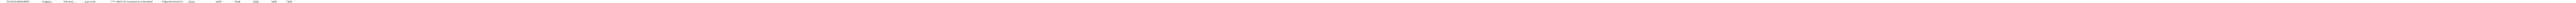

my test event in the malacca straits


#THIS WOULD BE SICKNESS 
Thinking ahead, I need to figure out how I'm going to joint this data. Take the average for a certain time period for a 
certain area around each point? Try to find as close to an exact match as possible? if I do least squared distance of all three
coordinates (time, lat, lon) at once, it may give me a solution that is from a different day or might sacrifice too much in one area making it not realistic (maybe? JUST MY assumption). I could guarantee I'm no worse than XXX time stamp off if I \
first constrict by a geographic area then constrict that data by time. (more control/understanding of where my error is coming from). 
If I had more time I would try each of those methods and visually inspect some data points to see what it's giving me:
   1. "least squares" of all three coords
   2. Constrict first by geographic location then by closest time - this makes most sense to me given time constraints
   3. Constrict by time, then by geographic location (tradeoff on variability of weather when concerning time vs location differences. I'd think time has a bigger factor once you constrict to a certain region. kind of swaps back and forth as you constrict: Example, galapagos islands are far different from antartica. But once i've established im in the galapagos. A difference of 10 NM between data points would likely have a far smaller affect on difference in weather than time would (one day to another). but this likely depends on what variables you are inspecting (wave characteristics might be more based on ocean topography and current locations whereas air temperature deals far more with time of day) 

Given netCDF has data that is associated already with a time, lat, lon....can I write some code that returns the entry in this dataset that is closest to the data 




Or do i just want to read this into a pandas dataframe so I can manipulate it from there? 

In [35]:
#this might prove helpful though it might not if I have to apply this to every one of the inputs
class Coord:
    '''An improved class to represent lat/lon values.'''

    def __init__(self,lat,lon):
        self.lat = float(lat)  # make sure it's a float
        self.lon = float(lon)

    # Follows the specification described in the Aviation Formulary v1.46
    # by Ed Williams (originally at http://williams.best.vwh.net/avform.htm)
    def dist_to(self, other):
        lat1 = Coord.deg2rad(self.lat)
        lon1 = Coord.deg2rad(self.lon)
        lat2 = Coord.deg2rad(other.lat)
        lon2 = Coord.deg2rad(other.lon)

        # there are two implementations of this function.
        # implementation #1:
        #dist_rad = math.acos(math.sin(lat1) * math.sin(lat2)
        #                   + math.cos(lat1) * math.cos(lat2) * math.cos(lon1-lon2))

        # implementation #2: (less subject to numerical error for short distances)
        dist_rad=2*math.asin(math.sqrt((math.sin((lat1-lat2)/2))**2 +
                   math.cos(lat1)*math.cos(lat2)*(math.sin((lon1-lon2)/2))**2))

        return Coord.rad2nm(dist_rad)
    
    def __str__(self):
        return "(%f,%f)" % (self.lat,self.lon)

    def __repr__(self):
        return "Coord(%f,%f)" % (self.lat,self.lon)

    def deg2rad(degrees):
        '''Converts degrees (in decimal) to radians.'''
        return (math.pi/180)*degrees

    def rad2nm(radians):
        '''Converts a distance in radians to a distance in nautical miles.'''
        return ((180*60)/math.pi)*radians

# end of class Coord

#i dont want to write a function that has to apply to  358,482,680 lines of code...would rather take a simple subtraction
#maybe take the least squared difference in lat lon? 

#or I could write code that creates a datasubset for each of the piracy incidents with a set buffer of time/space so that it
#automatically separates out feasible points that will narrow my search to both a smaller time horizon, and a 

This whole time I've been approaching this as "Given all of this weather data, I've got to find the points that match the piracy incidents" but the epiphany lies in knowing the details of each incident and using that to narrow my search "Given then piracy incidents, find the weather data that closely matches" slightly nuanced difference and definitely some computational implications

    this will negate my need to use the stupid great distance calculator for every point / or i can do it on just far less data

Therefore, let's try to do it for the one event 
            
                5/28/2022	Magnum Energy	Marshall Islands	Bulk carrier	In international waters	1.141666667	103.475	Not Reported	Store Rooms	Steaming	Knives	FALSE	FALSE	FALSE	FALSE	FALSE
                
Then throw a loop on that bad boy


***note: one of the dificulties here is that I don't have a csv file where I can inspect each individual netCDF entry and see what it looks like. Kinda working theoretically here

**Note: Do i care about what the day looked like on average moreso than the specific time of the incident? 


In [127]:
#read in clean dataset
piracy_df = pd.read_csv('Data_Files\[Clean] IMO Piracy - 2000 to 2022 (PDV 01-2023).csv')
piracy_df_map = piracy_df.dropna(subset=['Latitude','Longitude']) #drop lat/long nulls: actually useful info on map

In [128]:
piracy_df_names = piracy_df_map.set_index('Ship Name')

In [129]:
piracy_df_names

,Incident Date,Ship Flag,Ship Type,Area,Latitude,Longitude,Consequences to Crew,Part of Ship Raided,Ship Status,Weapons Used,Flag - Crew Injuries,Flag - Crew Held Hostage,Flag - Crew Missing,Flag - Crew Deaths,Flag - Crew Assaulted
Ship Name,,,,,,,,,,,,,,,
ABDI KHAN,4/16/2011,Yemen,Fishing vessel,In international waters,11.900000,54.083333,Ship Hijacked,Not Stated,Steaming,None or Not Reported,False,True,False,False,False
GHAZAL HOWLF,3/2/2012,Yemen,Dhow,In international waters,12.933333,49.166667,Ship Hijacked,Not Stated,Steaming,None or Not Reported,False,True,False,False,False
ALABASS,4/21/2012,Yemen,Dhow,In international waters,15.333333,52.200000,Ship Hijacked,Not Stated,Steaming,None or Not Reported,False,False,False,False,False
GNA,4/26/2009,Yemen,Tanker,In international waters,13.425000,47.406667,Ship Hijacked,Not Stated,Steaming,None or Not Reported,False,False,False,False,False
SAAVEDRA TIDE,12/4/2018,Vanuatu,Supply ship,In international waters,3.133333,6.333333,Not Reported,Not Stated,Steaming,None or Not Reported,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VOLME,4/26/2015,Bahamas,Bulk carrier,In territorial waters,1.263500,104.171333,No Consequences or Not Stated,Engine Room,Steaming,None or Not Reported,False,False,False,False,False
GULF ELAN,12/30/2009,Bahamas,Chemical tanker,In port area,22.690000,113.696667,No Consequences or Not Stated,Engine Room,At Anchor,None or Not Reported,False,False,False,False,False
CEC FUTURE,11/7/2008,Bahamas,General cargo ship,In international waters,12.766667,45.933333,Ship Hijacked,Engine Room,Steaming,None or Not Reported,False,True,False,False,False


In [69]:
piracy_df_names.loc['Magnum Energy']

Incident_Date                   2022-05-28 00:00:00
Ship Flag                          Marshall Islands
Ship Type                              Bulk carrier
Area                        In international waters
Latitude                                   1.141667
Longitude                                   103.475
Consequences to Crew                   Not Reported
Part of Ship Raided                     Store Rooms
Ship Status                                Steaming
Weapons Used                                 Knives
Flag - Crew Injuries                          False
Flag - Crew Held Hostage                      False
Flag - Crew Missing                           False
Flag - Crew Deaths                            False
Flag - Crew Assaulted                         False
Name: Magnum Energy, dtype: object

In [151]:
piracy_df_names = piracy_df_names.rename(columns={"Incident Date": "Incident_Date"}, errors="raise") 
#doing this because i cant use .Incident_Date to call that column without renaming it 

In [ ]:
#Step 1: determine my buffer / can play with this once I start seeing data or not seeing data
time_buffer = 1 #day 
lat_buffer = 1 #degree 
lon_buffer = 1 #degree

#Step 2: Extract the lat, lon from piracy event, save as coord class
    #do i want to just make a coord class set and add it to the piracy events? 
    #could save it as a coord class then use the dist_to method already built in babyyyyyyyyyy (must save target as Coord as well)

 
    
    
#Step 3: create a subset of data with the buffer to the BUENA REINA event (located in the malacca box)
     #realizing I can just skip the subset malacca step and pull these strait from the DS but I'll continue with this 
    #as it is a smaller subset, then try it direct and compare
 
subset_malacca = DS[['VHM0', 'VMDR', 'VCMX']].sel(longitude=slice(93,110),latitude=slice(-10,10))
subset_malacca_BUENA_REINA = DS[['VHM0', 'VMDR', 'VCMX']].sel(longitude=slice(93,110),latitude=slice(-10,10))

In [152]:
#convert piracy_df_names incident dates to datetimes
piracy_df_names['Incident_Date'] = pd.to_datetime(piracy_df_names['Incident_Date'])
piracy_df_names['Incident_Date']

Ship Name
ABDI KHAN       2011-04-16
GHAZAL HOWLF    2012-03-02
ALABASS         2012-04-21
GNA             2009-04-26
SAAVEDRA TIDE   2018-12-04
                   ...    
VOLME           2015-04-26
GULF ELAN       2009-12-30
CEC FUTURE      2008-11-07
ELLEN S         2009-10-24
PRINCESS MARY   2006-06-05
Name: Incident_Date, Length: 2810, dtype: datetime64[ns]

In [153]:
#first testing the time buffer for the specific instance, then putting it into a loop
#setting buffers so I have data that straddles the event in a 1x1 degree box lat/lon and 1 day (12 hours before 12 after)
time_buffer = pd.Timedelta(0.5, unit="h") #d "day", h "hour", m "minute"
lat_buffer = 0.05 #degree 
lon_buffer = 0.05 #degree

#set the lat and lon to the Magnum Energy event
lat = piracy_df_names.loc['Magnum Energy'].Latitude
lon = piracy_df_names.loc['Magnum Energy'].Longitude
Coord_Magnum = Coord(lat,lon)
time = piracy_df_names.loc['Magnum Energy'].Incident_Date
test_coord = Coord(10,93) #Top left corner of Malacca box 10 deg N, 93 deg E
Coord_Magnum.dist_to(test_coord) #output is Nautical Miles

820.3469873948201

In [154]:
#Use the buffer to make a subset of the weather data for points around the event
lat_add = lat + lat_buffer
lat_subtract = lat - lat_buffer
lon_add = lon + lon_buffer
lon_subtract = lon - lon_buffer
time_add = time + time_buffer
time_subtract = time - time_buffer

In [155]:
#create my data subset for the bubble around this specific piracy event
subset_Magnum_Energy = DS[['VHM0', 'VMDR', 'VCMX']].sel(
    latitude = slice(lat_subtract,lat_add),
    longitude = slice(lon_subtract,lon_add),
    time = slice(time_subtract, time_add)   )

In [156]:
subset_Magnum_Energy
#Inspecting the dataset, need to widen my box seems like the data isn't in this particular cell
#Longitude data is there but latitude is empty, i'm going to relax the slicing of the latitude data and see if anything comes up


<xarray.Dataset>
Dimensions:    (time: 1, latitude: 1, longitude: 1)
Coordinates:
  * latitude   (latitude) float64 1.167
  * longitude  (longitude) float64 103.5
  * time       (time) datetime64[ns] 2022-05-28
Data variables:
    VHM0       (time, latitude, longitude) float32 ...
    VMDR       (time, latitude, longitude) float32 ...
    VCMX       (time, latitude, longitude) float32 ...
Attributes: (12/16)
    Conventions:           CF-1.6
    area:                  GLO
    contact:               servicedesk.cmems@mercator-ocean.eu
    credit:                E.U. Copernicus Marine Service Information (CMEMS)
    geospatial_lat_max:    90.0
    geospatial_lat_min:    -80.0
    ...                    ...
    geospatial_lon_step:   0.0833282470703125
    geospatial_lon_units:  degree
    institution:           METEO-FRANCE
    producer:              CMEMS - Global Monitoring and Forecasting Centre
    product:               GLOBAL_ANALYSIS_FORECAST_WAV_001_027
    references:            http://marine.copernicus.eu

In [139]:
print(subset_Magnum_Energy['VHM0'])

<xarray.DataArray 'VHM0' (time: 1, latitude: 1, longitude: 1)>
[1 values with dtype=float32]
Coordinates:
  * latitude   (latitude) float64 1.167
  * longitude  (longitude) float64 103.5
  * time       (time) datetime64[ns] 2022-05-28
Attributes:
    WMO_code:          100
    cell_methods:      time:point area:mean
    long_name:         Spectral significant wave height (Hm0)
    standard_name:     sea_surface_wave_significant_height
    type_of_analysis:  spectral analysis
    units:             m


In [192]:
wave = subset_Magnum_Energy['VHM0']
wave.values[0][0][0]

0.29

In [157]:
df = subset_Magnum_Energy['VHM0'].to_dataframe()
df 

,,,VHM0
time,latitude,longitude,
2022-05-28,1.166667,103.5,0.29


In [144]:
print(lat, lon)
#NOT HALF FOOKIN BAD MATEY - not sure if my dimension buffer will always filter out leaving only one but lets keep chuggin

1.141666667 103.475


In [146]:
df = subset_Magnum_Energy[['VHM0', 'VMDR', 'VCMX']].to_dataframe()
df
#Notice there is a NaN value for the max wave height VCMX......don't really need it....or the wave direciton for that matter. 
#but it raises the question of what do I do if I have a NaN value and have to expand the buffer, thus letting in potentially
#more than one value for a particular coordinate? That is when I'd use the nearest method or .minarg stack overflow

,,,VHM0,VMDR,VCMX
time,latitude,longitude,,,
2022-05-28,1.166667,103.5,0.29,292.890015,NaN


In [ ]:
#For future use from youtube video
#df.to_csv('/home/FinalProject.csv')

In [158]:
piracy_df_names

,Incident_Date,Ship Flag,Ship Type,Area,Latitude,Longitude,Consequences to Crew,Part of Ship Raided,Ship Status,Weapons Used,Flag - Crew Injuries,Flag - Crew Held Hostage,Flag - Crew Missing,Flag - Crew Deaths,Flag - Crew Assaulted
Ship Name,,,,,,,,,,,,,,,
ABDI KHAN,2011-04-16,Yemen,Fishing vessel,In international waters,11.900000,54.083333,Ship Hijacked,Not Stated,Steaming,None or Not Reported,False,True,False,False,False
GHAZAL HOWLF,2012-03-02,Yemen,Dhow,In international waters,12.933333,49.166667,Ship Hijacked,Not Stated,Steaming,None or Not Reported,False,True,False,False,False
ALABASS,2012-04-21,Yemen,Dhow,In international waters,15.333333,52.200000,Ship Hijacked,Not Stated,Steaming,None or Not Reported,False,False,False,False,False
GNA,2009-04-26,Yemen,Tanker,In international waters,13.425000,47.406667,Ship Hijacked,Not Stated,Steaming,None or Not Reported,False,False,False,False,False
SAAVEDRA TIDE,2018-12-04,Vanuatu,Supply ship,In international waters,3.133333,6.333333,Not Reported,Not Stated,Steaming,None or Not Reported,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VOLME,2015-04-26,Bahamas,Bulk carrier,In territorial waters,1.263500,104.171333,No Consequences or Not Stated,Engine Room,Steaming,None or Not Reported,False,False,False,False,False
GULF ELAN,2009-12-30,Bahamas,Chemical tanker,In port area,22.690000,113.696667,No Consequences or Not Stated,Engine Room,At Anchor,None or Not Reported,False,False,False,False,False
CEC FUTURE,2008-11-07,Bahamas,General cargo ship,In international waters,12.766667,45.933333,Ship Hijacked,Engine Room,Steaming,None or Not Reported,False,True,False,False,False


In [171]:
piracy_df_names.index

Index([      'ABDI KHAN',    'GHAZAL HOWLF',         'ALABASS',
                   'GNA',   'SAAVEDRA TIDE',       'Tango Rey',
       'Wayne / Rig T20',      'ASD JAGUAR',           'QUEST',
        'MAERSK ALABAMA',
       ...
            'AKIJ GLOBE',           'ISMAR',          'Nefeli',
        'African Merlin',    'HUGLI SPIRIT',           'VOLME',
             'GULF ELAN',      'CEC FUTURE',         'ELLEN S',
         'PRINCESS MARY'],
      dtype='object', name='Ship Name', length=2810)

In [180]:
#dont want ship name in index anymore because its jacking up my for loop below 
#reset index 
piracy_df_reset = piracy_df_names.reset_index()
piracy_df_reset = piracy_df_reset.rename(columns={"Ship Name": "Ship_Name"}, errors="raise")
piracy_df_reset

,Ship_Name,Incident_Date,Ship Flag,Ship Type,Area,Latitude,Longitude,Consequences to Crew,Part of Ship Raided,Ship Status,Weapons Used,Flag - Crew Injuries,Flag - Crew Held Hostage,Flag - Crew Missing,Flag - Crew Deaths,Flag - Crew Assaulted,Mean_Wave_Height_m
0,ABDI KHAN,2011-04-16,Yemen,Fishing vessel,In international waters,11.900000,54.083333,Ship Hijacked,Not Stated,Steaming,None or Not Reported,False,True,False,False,False,0
1,GHAZAL HOWLF,2012-03-02,Yemen,Dhow,In international waters,12.933333,49.166667,Ship Hijacked,Not Stated,Steaming,None or Not Reported,False,True,False,False,False,0
2,ALABASS,2012-04-21,Yemen,Dhow,In international waters,15.333333,52.200000,Ship Hijacked,Not Stated,Steaming,None or Not Reported,False,False,False,False,False,0
3,GNA,2009-04-26,Yemen,Tanker,In international waters,13.425000,47.406667,Ship Hijacked,Not Stated,Steaming,None or Not Reported,False,False,False,False,False,0
4,SAAVEDRA TIDE,2018-12-04,Vanuatu,Supply ship,In international waters,3.133333,6.333333,Not Reported,Not Stated,Steaming,None or Not Reported,False,False,False,False,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2805,VOLME,2015-04-26,Bahamas,Bulk carrier,In territorial waters,1.263500,104.171333,No Consequences or Not Stated,Engine Room,Steaming,None or Not Reported,False,False,False,False,False,0
2806,GULF ELAN,2009-12-30,Bahamas,Chemical tanker,In port area,22.690000,113.696667,No Consequences or Not Stated,Engine Room,At Anchor,None or Not Reported,False,False,False,False,False,0
2807,CEC FUTURE,2008-11-07,Bahamas,General cargo ship,In international waters,12.766667,45.933333,Ship Hijacked,Engine Room,Steaming,None or Not Reported,False,True,False,False,False,0
2808,ELLEN S,2009-10-24,Antigua and Barbuda,Container ship,In territorial waters,20.641667,106.880000,Not Reported,Engine Room,At Anchor,None or Not Reported,False,False,False,False,False,0


In [181]:
#working through a loop
#going to want to parse out my events into dates that correspond to the dates each dataset has data on 
#For this case with the wave data from 30 Sep 2021 to 25 Mar 2024 
DS_start_date = datetime.date(2021,9,30)
DS_end_date = datetime.date(2024,3,25)
count = 0
Ship_Coord_dict = {} #initialize an empty dictionary to fill with Coord class values for the lat/lon of each ship
for index, row in piracy_df_reset.iterrows():
    if row['Incident_Date'] >= DS_start_date:
        #print(row['Incident_Date'])
        lat = row['Latitude']
        lon = row['Longitude']
        Ship_Coord = Coord(lat, lon)
        Ship_Coord_dict[row['Ship_Name']] = Ship_Coord
        count +=1
print(count)

145


In [182]:
Ship_Coord_dict #these are all of the ship names of piracy events that I have wave data for (potentially)

{'Wayne / Rig T20': Coord(1.354333,103.293500),
 'Hai Duong 29 (& Hakuryu 5)': Coord(1.173167,103.478333),
 'Armenistis': Coord(7.200000,-13.283333),
 'HK Tug 9 / LKH 7887': Coord(10.376167,107.040000),
 'HK Tug 9  (LKH 2882  Barge)': Coord(1.292667,104.157833),
 'Maersk Bering': Coord(3.787833,98.697333),
 'Jindal Pioneer': Coord(18.400000,-93.794667),
 'HK Tug 9  (LKH 2882)': Coord(1.288167,104.338167),
 'Canopus Leader': Coord(13.756667,121.037833),
 'Tampa Trader': Coord(18.666667,-72.391667),
 'Barlian 1299': Coord(-1.704833,104.854667),
 'Maersk Belfast': Coord(1.069833,104.138667),
 'Samwoh Gallant': Coord(1.187833,103.550667),
 'KT Birdie': Coord(1.066167,103.600667),
 'NYK Fushimi': Coord(-5.996500,106.898333),
 'Nord Steady': Coord(3.890500,-77.062167),
 'Lord Vishnu': Coord(-12.016000,-77.193167),
 'Pacific Dolphin': Coord(-6.076500,12.311667),
 'Name Withheld': Coord(3.190333,7.817000),
 'CH Doris': Coord(1.246000,104.053500),
 'Oriental Hibiscus': Coord(22.793167,70.068167

In [164]:
#make a new column of 0s for wave height to be added in after looping through
piracy_df_names["Mean_Wave_Height_m"] = 0
piracy_df_names

,Incident_Date,Ship Flag,Ship Type,Area,Latitude,Longitude,Consequences to Crew,Part of Ship Raided,Ship Status,Weapons Used,Flag - Crew Injuries,Flag - Crew Held Hostage,Flag - Crew Missing,Flag - Crew Deaths,Flag - Crew Assaulted,Mean_Wave_Height_m
Ship Name,,,,,,,,,,,,,,,,
ABDI KHAN,2011-04-16,Yemen,Fishing vessel,In international waters,11.900000,54.083333,Ship Hijacked,Not Stated,Steaming,None or Not Reported,False,True,False,False,False,0
GHAZAL HOWLF,2012-03-02,Yemen,Dhow,In international waters,12.933333,49.166667,Ship Hijacked,Not Stated,Steaming,None or Not Reported,False,True,False,False,False,0
ALABASS,2012-04-21,Yemen,Dhow,In international waters,15.333333,52.200000,Ship Hijacked,Not Stated,Steaming,None or Not Reported,False,False,False,False,False,0
GNA,2009-04-26,Yemen,Tanker,In international waters,13.425000,47.406667,Ship Hijacked,Not Stated,Steaming,None or Not Reported,False,False,False,False,False,0
SAAVEDRA TIDE,2018-12-04,Vanuatu,Supply ship,In international waters,3.133333,6.333333,Not Reported,Not Stated,Steaming,None or Not Reported,False,False,False,False,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VOLME,2015-04-26,Bahamas,Bulk carrier,In territorial waters,1.263500,104.171333,No Consequences or Not Stated,Engine Room,Steaming,None or Not Reported,False,False,False,False,False,0
GULF ELAN,2009-12-30,Bahamas,Chemical tanker,In port area,22.690000,113.696667,No Consequences or Not Stated,Engine Room,At Anchor,None or Not Reported,False,False,False,False,False,0
CEC FUTURE,2008-11-07,Bahamas,General cargo ship,In international waters,12.766667,45.933333,Ship Hijacked,Engine Room,Steaming,None or Not Reported,False,True,False,False,False,0


In [196]:
#build out the for loop to do more steps in one iteration 
#For this case with the wave data from 30 Sep 2021 to 25 Mar 2024 
DS_start_date = datetime.date(2021,9,30)
DS_end_date = datetime.date(2024,3,25)
#Ship_Coord_dict = {} #initialize an empty dictionary to fill with Coord class values for the lat/lon of each ship
df_wave = pd.DataFrame(columns=['Ship_Name', "Mean_Wave_Height_m", 'Ship_Coord'])

for index, row in piracy_df_reset.iterrows():
    if row['Incident_Date'] >= DS_start_date:
        #print(row['Incident_Date'])
        lat = row['Latitude']
        lon = row['Longitude']
        Ship_Coord = Coord(lat, lon)
        #Ship_Coord_dict[row['Ship_Name']] = Ship_Coord
        
        #Use the buffer to make a subset of the weather data for points around the event
        lat_add = lat + lat_buffer
        lat_subtract = lat - lat_buffer
        lon_add = lon + lon_buffer
        lon_subtract = lon - lon_buffer
        time = row['Incident_Date']
        time_add = time + time_buffer
        time_subtract = time - time_buffer
        
        #create my data subset for the bubble around this specific piracy event for wave height
        #hopefully this is only going to return one value for each point but it may return more or none
        subset = DS['VHM0'].sel(
            latitude = slice(lat_subtract,lat_add),
            longitude = slice(lon_subtract,lon_add),
            time = slice(time_subtract, time_add)   )
        print(f'Stopped on {row["Ship_Name"]}')
        #this is probably taking most time in the loop but i don't know how else to extract the actual wave height value
        #create a dataframe containing all readings within the buffer zone for each piracy incident
        df_subset = subset['VHM0'].to_dataframe()
        print(df_subset)
        df_subset = df_subset.rename(columns={"VHM0": "Mean_Wave_Height_m"}, errors="raise")
        
        #update that dataframe with a column "Ship_Name" = the ship's name...also add Coord class in there (might be able to 
        #skip making a dictionary for the ship coords)
        df_subset['Ship_Name'] = row['Ship_Name']
        df_subset['Coord'] = Ship_Coord #might work, but might break it 
        
        #concatenate to append the new df_subset values to the overall df_wave that will hold all values for all ship names
        df_wave =  pd.concat([df_wave, df_subset], ignore_index = True)

df_wave

Stopped on Wayne / Rig T20


KeyError: 'VHM0'

In [ ]:
wave = subset_Magnum_Energy['VHM0']
wave.values[0][0][0]